# ID5059 - Group Assignment

## Imports

In [19]:
from unicodedata import category

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Data Initial Check

In [20]:
with open('data/train.csv') as f:
    print(f.readline())  # look into the first line to the separation mark.

id,valid_time,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m



In [21]:
data = pd.read_csv('data/train.csv')
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42) # Split train and validate data sets
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

train_df.head()

Train shape: (10631136, 13)
Validation shape: (2657784, 13)


,id,valid_time,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m
7708398,7708399,2018-07-31 17:00:00,56.00,-0.75,0.000000,2.117569,8.345276,101296.94,3.671143,10.726196,0.398621,0.0,290.68433
8477046,8477047,2018-08-21 20:00:00,58.75,-5.75,0.000913,5.980820,9.166794,100456.50,8.365173,11.827179,1.000000,1.0,287.38440
1727451,1727452,2018-02-17 10:00:00,52.50,1.75,0.000000,-1.023087,3.779327,102173.44,-1.325638,5.412933,0.307495,0.0,278.67260
6087389,6087390,2018-06-17 04:00:00,52.00,1.25,0.000000,5.188187,1.900284,101178.25,7.420486,2.424911,1.000000,0.0,286.73853
1210940,1210941,2018-02-03 06:00:00,56.75,-6.75,0.000097,6.590653,-6.228958,100491.25,7.399139,-6.996277,0.369110,1.0,280.39430


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10631136 entries, 7708398 to 6423388
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   valid_time  object 
 2   latitude    float64
 3   longitude   float64
 4   tp          float64
 5   u10         float64
 6   v10         float64
 7   sp          float64
 8   u100        float64
 9   v100        float64
 10  tcc         float64
 11  ptype       float64
 12  t2m         float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.1+ GB


Notice 'valid_time' is object, it'll need to be translated into numbers.

In [23]:
# Translate valid_time to numbers
def extract_datetime(df):
    df['valid_time'] = pd.to_datetime(df['valid_time'])
    df['year'] = df['valid_time'].dt.year
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.day
    df['hour'] = df['valid_time'].dt.hour
    df['weekday'] = df['valid_time'].dt.weekday
    return df.drop(columns=['valid_time', 'id'])

# Apply it to train and val sets
train_df = extract_datetime(train_df)
val_df = extract_datetime(val_df)

In [24]:
train_df.describe()

,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m,year,month,day,hour,weekday
count,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07,10631136.0,1.063114e+07,1.063114e+07,1.063114e+07,1.063114e+07
mean,5.450017e+01,-2.999218e+00,1.154980e-04,1.055956e+00,1.496121e+00,1.005303e+05,1.570115e+00,2.100078e+00,6.968678e-01,8.030809e-01,2.832999e+02,2018.0,6.525666e+00,1.571997e+01,1.150072e+01,2.991427e+00
std,2.669365e+00,2.958265e+00,3.219564e-04,5.056132e+00,4.823542e+00,1.645716e+03,6.598667e+00,6.325789e+00,3.447786e-01,1.069687e+00,4.900049e+00,0.0,3.447943e+00,8.795697e+00,6.922935e+00,2.003254e+00
min,5.000000e+01,-8.000000e+00,0.000000e+00,-1.956340e+01,-1.882382e+01,9.068581e+04,-2.401868e+01,-2.411224e+01,0.000000e+00,0.000000e+00,2.596375e+02,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.225000e+01,-5.500000e+00,0.000000e+00,-2.050995e+00,-1.637653e+00,9.963225e+04,-2.823135e+00,-2.273514e+00,4.150085e-01,0.000000e+00,2.798364e+02,2018.0,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00
50%,5.450000e+01,-3.000000e+00,3.814697e-06,1.158585e+00,1.341110e+00,1.008086e+05,1.857498e+00,1.808304e+00,8.707275e-01,1.000000e+00,2.832053e+02,2018.0,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+00
75%,5.675000e+01,-5.000000e-01,6.437302e-05,4.235077e+00,4.463898e+00,1.017068e+05,6.024475e+00,6.250885e+00,1.000000e+00,1.000000e+00,2.866834e+02,2018.0,1.000000e+01,2.300000e+01,1.800000e+01,5.000000e+00
max,5.900000e+01,2.000000e+00,1.098633e-02,2.499036e+01,2.315897e+01,1.043716e+05,3.178088e+01,2.940465e+01,1.000000e+00,8.000000e+00,3.080288e+02,2018.0,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00


In [25]:
train_df.isnull().sum()

latitude     0
longitude    0
tp           0
u10          0
v10          0
sp           0
u100         0
v100         0
tcc          0
ptype        0
t2m          0
year         0
month        0
day          0
hour         0
weekday      0
dtype: int64

## Target Variable Exploration

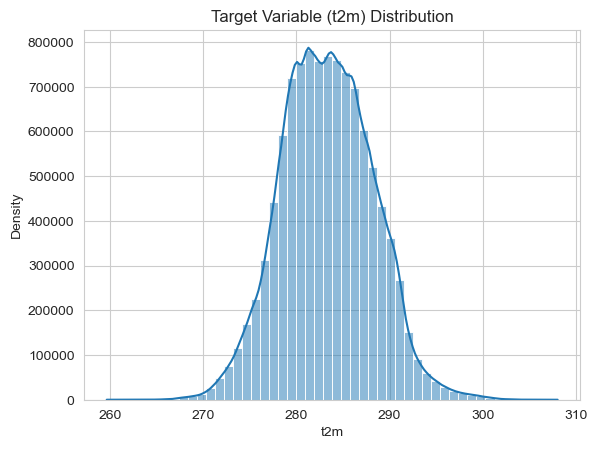

In [26]:
sns.histplot(train_df['t2m'], kde=True, bins=50)
plt.title('Target Variable (t2m) Distribution')
plt.xlabel('t2m')
plt.ylabel('Density')
plt.show()

## Random Forest Forcast

MSE: 0.5239199919229021
R²: 0.9781315917540457


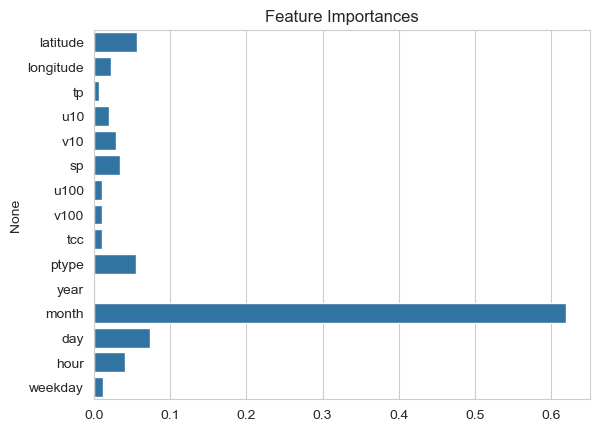

In [28]:
# Take 5% as a sample to train and validate the dataset
train_sample = train_df.sample(frac=0.05, random_state=42)
val_sample = val_df.sample(frac=0.05, random_state=42)

# Prepare the X and Y for the forcast
X_train = train_sample.drop(columns=['t2m'])
y_train = train_sample['t2m']

X_val = val_sample.drop(columns=['t2m'])
y_val = val_sample['t2m']

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Make the prediction
y_pred = model.predict(X_val)

# Evaluation
print("MSE:", mean_squared_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

# Feature importances
sns.barplot(x=model.feature_importances_, y=X_train.columns)
plt.title("Feature Importances")
plt.show()



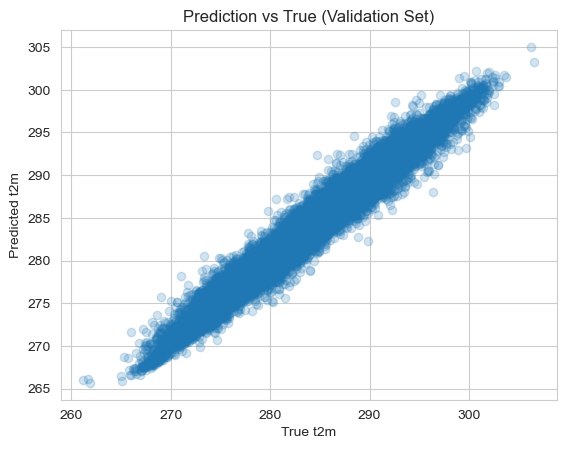

In [29]:
# To compare the true data and prediction
plt.scatter(y_val, y_pred, alpha=0.2)
plt.xlabel("True t2m")
plt.ylabel("Predicted t2m")
plt.title("Prediction vs True (Validation Set)")
plt.grid(True)
plt.show()